# Module 8

## Video 34: Hypothesis Testing I
**Python for the Energy Industry**

If we have a hypothesis about how two variables are related, we may wish to test this hypothesis statistically using data from the SDK. In this lesson and the next, we will see how to do this. This first lesson focuses on looking at the correlation between time series data.

[Here is a good example of these concepts applied.](https://github.com/VorTECHsa/python-sdk/blob/master/docs/examples/Crude_Floating_Storage.ipynb)

In [1]:
# initial imports
import pandas as pd
import numpy as np
from datetime import datetime
from dateutil.relativedelta import relativedelta
import vortexasdk as v
# The cargo unit for the time series (barrels)
TS_UNIT = 'b'

# The granularity of the time series
TS_FREQ = 'day'

# datetimes to access last 7 weeks of data
now = datetime.utcnow()
seven_weeks_ago = now - relativedelta(weeks=7)

We will consider a fairly trivial example here to demonstrate the process - let's say we want to consider the correlation between crude exports out of Southeast Asia destined for China, with the crude imports into China that originated in Southeast Asia. These are clearly strongly correlated, with a time lag that depends on travel time. Let's start by accessing these exports and imports datasets:

In [2]:
crude = [p.id for p in v.Products().search('crude').to_list() if p.name=='Crude']
assert len(crude) == 1

china = v.Geographies().search('China',exact_term_match=True)[0]['id']
SEA = v.Geographies().search('Southeast Asia (SEA)',exact_term_match=True)[0]['id']

SEA_exports = v.CargoTimeSeries().search(
    timeseries_frequency=TS_FREQ,
    timeseries_unit=TS_UNIT,
    filter_time_min=seven_weeks_ago,
    filter_time_max=now,
    filter_activity="loading_end",
    filter_origins=SEA,
    filter_destinations=china,
).to_df()

SEA_exports = SEA_exports.rename(columns={'key':'date','value':'SEA_exp'})[['date','SEA_exp']]

In [3]:
china_imports = v.CargoTimeSeries().search(
    timeseries_frequency=TS_FREQ,
    timeseries_unit=TS_UNIT,
    filter_time_min=seven_weeks_ago,
    filter_time_max=now,
    filter_activity="unloading_start",
    filter_origins=SEA,
    filter_destinations=china,
).to_df()

china_imports = china_imports.rename(columns={'key':'date','value':'china_imp'})[['date','china_imp']]

Combine the exports and imports data into one DataFrame:

In [4]:
combined_df = SEA_exports
combined_df['china_imp'] = china_imports['china_imp']

# use dropna in case any NaN results are returned by the query
combined_df = combined_df.dropna()

combined_df.head()

,date,SEA_exp,china_imp
0,2020-10-23 00:00:00+00:00,1322832,2670087
1,2020-10-24 00:00:00+00:00,3562655,2940471
2,2020-10-25 00:00:00+00:00,4314260,2373007
3,2020-10-26 00:00:00+00:00,4277880,1440071
4,2020-10-27 00:00:00+00:00,3618404,1614060


Lets take a look at our two datasets and see if they look correlated:

<AxesSubplot:xlabel='date'>

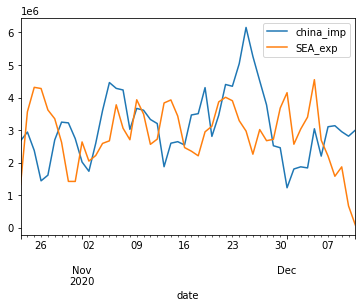

In [5]:
combined_df.plot(x='date',y=['china_imp','SEA_exp'])

It looks like they might be correlated, but to be sure we'll want to calculate the cross-correlation between the time series as a function of the number of lags. Let's write a function to do that:

In [6]:
def crosscorr(x, y, lag):
    return x.corr(y.shift(lag))

We then calculate the cross correlation between the two time series, across a range of lags up to 20 days in each direction. These values are put into a DataFrame and plotted:

<AxesSubplot:>

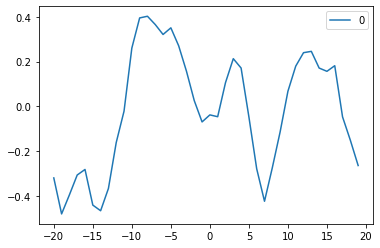

In [7]:
lags = np.arange(-20,20)
ccs = [crosscorr(combined_df['china_imp'], combined_df['SEA_exp'], lag) for lag in lags]
ccs_df = pd.DataFrame(ccs,index=lags)
ccs_df.plot()

*Note: [here is](https://www.usna.edu/Users/oceano/pguth/md_help/html/time0alq.htm) a good reference for a bit more detail on interpreting cross-correlation plots.*

Cross-correlation is difficult to interpret, because it can reflect autocorrelations within each time series. We can plot the cross-correlation of each time series with itself to get the autocorrelation:

<AxesSubplot:>

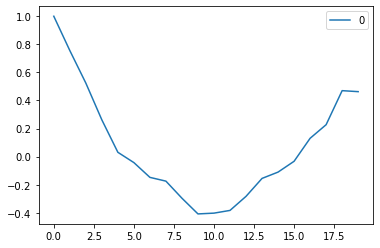

In [8]:
lags = np.arange(0,20)
acs1 = [crosscorr(combined_df['china_imp'], combined_df['china_imp'], lag) for lag in lags]
acs_df1 = pd.DataFrame(acs1,index=lags)
acs_df1.plot()

<AxesSubplot:>

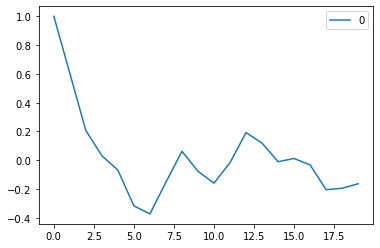

In [9]:
acs2 = [crosscorr(combined_df['SEA_exp'], combined_df['SEA_exp'], lag) for lag in lags]
acs_df2 = pd.DataFrame(acs2,index=lags)
acs_df2.plot()

We do indeed see that within each time series there is autocorrelation both on the short term, but also at longer time scales. We will need to do something else to disentagle this.

### Exercise

Pick 2 time series data sets that you would *not* expect to be correlated. Do the cross-correlation and autocorrelation plots confirm this?